# Dependencies



In [1]:
%cd drive/MyDrive/LLMs/wikipedia

/content/drive/MyDrive/LLMs/wikipedia


In [ ]:
!pip install datasets
!pip install textstat
!pip install wandb
!pip install -U sentence-transformers
!pip install apache-beam
!pip install transformers[torch] evaluate
!pip install mwparserfromhell
!pip install openai
!pip install wandb
!pip install tiktoken

In [3]:
from datasets import load_dataset, load_from_disk
from sentence_transformers import SentenceTransformer
from textstat import flesch_reading_ease as fre
from textstat import flesch_kincaid_grade as fkg
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


import os
import openai
import json
from getpass import getpass

from scipy.stats import kstest
import numpy as np
import wandb
import datetime
from datetime import datetime
from collections import defaultdict
from tqdm import tqdm

from itertools import product
import tiktoken

In [4]:
wandb.login()

%matplotlib inline

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Definitions

In [6]:
def flesch_scores(example):
    """
    Calculate Flesch Readability scores for each article
    """

    example['fre'] = fre(example['text'])
    example['fkg'] = fkg(example['text'])
    return example

def extract_article_text(example):
    """
    Extracts the text from a Wikipedia article before the "Related pages" and "References" sections.

    Parameters:
        example (dict): Dictionary with key 'text' which contains entire Wikipedia article content as a string.

    Returns:
        str: The article text before the "Related pages" and "References" sections.
    """
    text = example['text']

    # Find the positions of the "Related pages" and "References" sections
    txt_lower = text.lower()

    related_pages_position = txt_lower.find('related pages')
    references_position = txt_lower.find('references')

    # Extract the text before the sections
    article_text = ""
    if related_pages_position != -1:
        # If the "Related pages" section is found, extract the text before it
        article_text = text[:related_pages_position]
    elif references_position != -1:
        # If the "References" section is found (but not the "Related pages" section),
        # extract the text before it
        article_text = text[:references_position]
    else:
        # If both sections are not present, return the entire text
        article_text = text

    # Remove leading and trailing whitespace from the extracted text
    article_text = article_text.strip()

    example['text'] = ' '.join(article_text.split())

    return example

def remove_sections(article):

    article_split = article.split('\n')
    article_split = [txt for txt in article_split if len(txt.split())>=5]

    return '\n'.join(article_split)




#def trunc_article(text, length=512,enc=None,max_length = 4096):
#    text = text.split('\n')
#    trunc_txt = text[0]
#    i=1
#
#    while len(trunc_txt)<=length and i<len(text):
#        trunc_txt += ' '+text[i]
#        i += 1
#
#    trunc_txt = ' '.join(trunc_txt.split())
#
#    if enc is not None:
#        trunc_txt_encoding = enc.encode(trunc_txt)
#        trunc_txt_encoding = trunc_txt_encoding[:max_length]
#        trunc_txt = enc.decode(trunc_txt_encoding)
#        try:
#            idx = trunc_txt[::-1].index('.')
#            trunc_txt = trunc_txt[:len(trunc_txt)-idx]
#        except:
#            pass
#
#    return trunc_txt.strip()


def system_message(message,extra=None):
    if extra is None:
        message = 'You are a helpful assistant that generates instructions from text.'
    else:
        message = f'You are a helpful assistant that generates instructions from text. {extra}'

def trunc_article(text,max_length=300):
    text = text.split()

    trunc_text = text[:max_length]

    trunc_text = ' '.join(trunc_text)

    if '.' in trunc_text:
        idx = trunc_text[::-1].index('.')
        trunc_text = trunc_text[:len(trunc_text)-idx]
    return trunc_text

# Comparing Readability

## Filter datasets

In [ ]:
english_wiki = load_dataset("wikipedia", "20220301.en")
simple_wiki = load_dataset("wikipedia", "20220301.simple")

In [ ]:
english_wiki.save_to_disk('./data/english_wiki')

Saving the dataset (0/41 shards):   0%|          | 0/6458670 [00:00<?, ? examples/s]

In [ ]:
simple_wiki_title = simple_wiki['train']['title']
shared_titles = set(simple_wiki_title).intersection(set(english_wiki['train']['title']))
diff_titles = set(english_wiki['train']['title']).union(set(simple_wiki_title))
diff_titles = diff_titles - set(english_wiki['train']['title']).intersection(set(simple_wiki_title))
only_in_simple = set(simple_wiki_title)-set(simple_wiki_title).intersection(set(english_wiki['train']['title']))

In [ ]:
english_wiki_shared = english_wiki.filter(
    lambda post: post['title'] in shared_titles
)

Filter:   0%|          | 0/6458670 [00:00<?, ? examples/s]

In [ ]:
simple_wiki_shared = simple_wiki.filter(
    lambda post: post['title'] in shared_titles
)

Filter:   0%|          | 0/205328 [00:00<?, ? examples/s]

In [ ]:
english_wiki_shared['train'] = english_wiki_shared['train'].map(extract_article_text)
simple_wiki_shared['train'] = simple_wiki_shared['train'].map(extract_article_text)

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

In [ ]:
english_wiki_shared['train'] = english_wiki_shared['train'].map(flesch_scores)
simple_wiki_shared['train'] = simple_wiki_shared['train'].map(flesch_scores)

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

Map:   0%|          | 0/179814 [00:00<?, ? examples/s]

In [ ]:
simple_wiki_shared.save_to_disk('./data/simple_wiki_shared')
english_wiki_shared.save_to_disk('./data/english_wiki_shared')

Saving the dataset (0/1 shards):   0%|          | 0/179814 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/179814 [00:00<?, ? examples/s]

## Figures

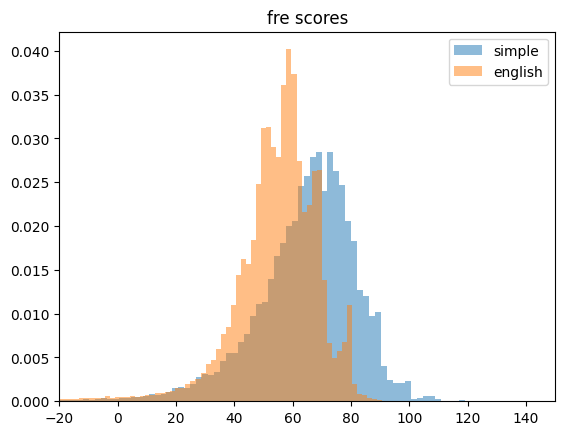

In [ ]:
fig, ax = plt.subplots()

ax.hist(simple_wiki_shared['train']['fre'],
         bins=2000,
         density=True,
         alpha=.5,
         label='simple')
ax.hist(english_wiki_shared['train']['fre'],
         bins=2000,
         density=True,
         alpha=.5,
         label='english')

ax.set_xlim(-20,150)
plt.title('fre scores')
plt.legend(loc='upper right')
plt.savefig('./figures/wiki_fre')
plt.show()

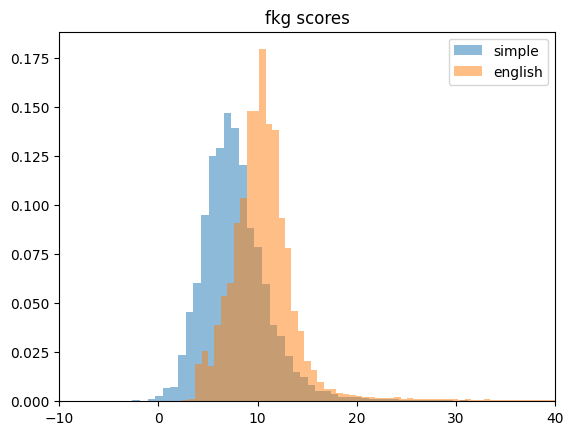

In [ ]:
fig, ax = plt.subplots()

ax.hist(simple_wiki_shared['train']['fkg'],
         bins=2000,
         density=True,
         alpha=.5,
         label='simple')
ax.hist(english_wiki_shared['train']['fkg'],
         bins=2000,
         density=True,
         alpha=.5,
         label='english')

ax.set_xlim(-10,40)
plt.title('fkg scores')
plt.legend(loc='upper right')
plt.savefig('./figures/wiki_fkg')
plt.show()

In [ ]:
fkg_scores = {}
fkg_scores['simple'] = simple_wiki_shared['train']['fkg']
fkg_scores['english'] = english_wiki_shared['train']['fkg']

fre_scores = {}
fre_scores['simple'] = simple_wiki_shared['train']['fre']
fre_scores['english'] = english_wiki_shared['train']['fre']

In [ ]:
kstest(np.array(fkg_scores['english']),np.array(fkg_scores['simple']))

KstestResult(statistic=0.42008408688978616, pvalue=0.0, statistic_location=8.5, statistic_sign=-1)

In [ ]:
kstest(np.array(fre_scores['english']),np.array(fre_scores['simple']))

KstestResult(statistic=0.34224810081528695, pvalue=0.0, statistic_location=63.32, statistic_sign=1)

# Make Simple Wiki Simple Again

In [ ]:
simple_wiki = load_dataset("wikipedia", "20220301.simple")

simple_wiki = simple_wiki.map(extract_article_text)
simple_wiki_scored = simple_wiki.map(flesch_scores)

simple_wiki_filt = simple_wiki_scored.filter(lambda article: article['fre']>=60
                                             and article['fkg']<9)

simple_wiki_split_tmp = (simple_wiki_filt['train']
                         .train_test_split(test_size=5000,seed=42))

simple_wiki_split = (simple_wiki_split_tmp['train']
                     .train_test_split(test_size=5000,seed=42))

simple_wiki_split['validation'] = simple_wiki_split_tmp['test']

simple_wiki_split.save_to_disk('./data/simple_wiki_split')

In [ ]:
simple_wiki_split = load_from_disk('./data/simple_wiki_split')

In [ ]:
now = datetime.now()
file_name = './data/simple_wiki_split'
time_stamp = now.strftime("%m.%d.%y-%H.%M.%S")
with wandb.init(project='ELI5_analysis',
                            entity='ft-llmmm',
                            job_type='log_data',
                            name=f'log_wiki_data_{time_stamp}') as run:
                # Initialize a WandB run for logging
                data_art = wandb.Artifact('simple_wiki_split', 'dataset')
                data_art.add_dir(file_name)
                run.log_artifact(data_art)

wandb: Currently logged in as: dmeltzer (ft-llmmm). Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (./data/simple_wiki_split)... Done. 1.3s


# Prompts

In [16]:
openai.api_key = getpass('Enter your OpenAI key: ')

model_engine = 'gpt-3.5-turbo'

enc = tiktoken.encoding_for_model(model_engine)

Enter your OpenAI key: ··········


In [8]:
simple_wiki = load_from_disk('./data/simple_wiki_split')

## Take 1

In [ ]:
def create_message(extra=None):
    if extra == 'default':
        extra = ''
    else:
        extra = ' '+extra
    message=f'You are a helpful assistant that generates questions from text.{extra}'

    return message

def create_prompt(text,
                  extra):

    if extra == 'default':
        extra = ''
    else:
        extra = ' '+extra
    prompt = f"Question: X\nOutput: {text}\nWhat kind of question, X, could this be an answer to?{extra}\nX:."
    return prompt

def GPT_instructions(text,
                     message_extra='default',
                     prompt_extra='default'):

    system_message = create_message(message_extra)
    prompt = create_prompt(text, prompt_extra)

    response=openai.ChatCompletion.create(
        model=model_engine,
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt},
        ],
        temperature = 0)

    instruction = response['choices'][0]['message']['content']

    return instruction

In [ ]:
message_extra = []
message_extra.append('default')
message_extra.append('You write text using Simple English.')
message_extra.append('You write text that is easy to understand.')
message_extra.append('You write text using the style of ELI5.')


prompt_extra = []
prompt_extra.append('default')
prompt_extra.append('Write the question using Simple English.')
prompt_extra.append('Write a question which is easy to understand.')
prompt_extra.append('Write a question in the style of ELI5.')

In [ ]:
simple_wiki = load_from_disk('./data/simple_wiki_split')

In [ ]:
sample_articles = list(map(trunc_article,simple_wiki['train']['text'][:10]))

In [ ]:
instruct_samples = []

for system_message_ext in tqdm(message_extra):
    for prmpt in prompt_extra:
        for article in sample_articles:

            instruct_dict = {}

            instruct_dict['article'] = article
            instruct_dict['system_message_ext'] = system_message_ext
            instruct_dict['prompt_ext'] = prmpt

            instruct_dict['instruction'] = GPT_instructions(article,
                                                               system_message_ext,
                                                               prmpt)

            instruct_samples.append(instruct_dict)

100%|██████████| 4/4 [02:42<00:00, 40.50s/it]


In [ ]:
df_instructions = pd.DataFrame(instruct_samples)

In [ ]:
question_samples = []

for system_message_ext in tqdm(message_extra):
    for prmpt in prompt_extra:
        for article in sample_articles:

            question_dict = {}

            question_dict['article'] = article
            question_dict['system_message_ext'] = system_message_ext
            question_dict['prompt_ext'] = prmpt

            question_dict['instruction'] = GPT_instructions(article,
                                                               system_message_ext,
                                                               prmpt)

            question_samples.append(question_dict)

100%|██████████| 4/4 [01:54<00:00, 28.53s/it]


In [ ]:
df_questions = pd.DataFrame(question_samples)

In [ ]:
df_questions.to_csv('./data/sample_prompts_Qs_10.csv')

In [ ]:
counter_Q = defaultdict(list)

for i in range(4):
    for j in range(4):

        temp = df_questions[(df_questions['system_message_ext']==message_extra[i])*(df_questions['prompt_ext']==prompt_extra[j])]
        cts = temp['instruction'].str.contains('Question:').sum()
        cts += temp['instruction'].str.contains('ELI5:').sum()

        counter_Q[cts].append((i,j))
counter_Q

defaultdict(list,
            {0: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 2), (3, 1)],
             6: [(0, 3), (1, 3), (2, 2)],
             1: [(1, 1), (3, 0)],
             3: [(2, 0), (2, 1)],
             13: [(2, 3)],
             2: [(3, 2)],
             8: [(3, 3)]})

In [ ]:
for i,j in options:
    print(f'message_extra: "{message_extra[i]}", prompt_extra: "{prompt_extra[j]}"')

    print(df_questions[((df_questions['system_message_ext']==message_extra[i]) &
     (df_questions['prompt_ext']==prompt_extra[j]))]['instruction'].values)
    print('\n')


message_extra: "default", prompt_extra: "default"
['What is the release date of Avengers: Age of Ultron?'
 'What was the Dixiecrat party and what were their beliefs?'
 'Who was Paul William Henning?'
 'What are natural arches commonly formed from?' 'What is Briarcliff?'
 'What is the Ballycroy National Park known for?'
 'Who is Jessica Oyelowo?' 'Who was Lee Alexander McQueen?'
 'Who is Kelly Olynyk and what is his basketball career like?'
 'What is the title and year of the American horror movie based on a Stephen King novel?']


message_extra: "default", prompt_extra: "Write the question using Simple English."
['What is Avengers: Age of Ultron?'
 'What was the Dixiecrat party and what were their beliefs?'
 'Who was Paul William Henning and what were some of his notable contributions in the entertainment industry?'
 'What are natural arches and how are they formed?'
 'What is Briarcliff and where is it located?'
 'What is the Ballycroy National Park and where is it located?'
 'Who is 

## Take 2

In [ ]:
def create_prompt(prompt_start,
                  text,
                  prompt_end
                  ):

    prompt = f"{prompt_start} {text} {prompt_end}"
    return prompt

def GPT_custom_prompt(message,
                      prompt_start,
                      text,
                      prompt_end):

    prompt = create_prompt(prompt_start,
                           text,
                           prompt_end)

    response=openai.ChatCompletion.create(
        model=model_engine,
        messages=[
            {"role": "system", "content": message},
            {"role": "user", "content": prompt},
        ],
        temperature = 0)

    instruction = response['choices'][0]['message']['content']

    return instruction

In [ ]:
system_messages_I = []
system_messages_I.append('You are a helpful assistant that generates instructions from text.')
system_messages_I.append('You are a helpful assistant that generates instructions from text. You write using Simple English.')


system_messages_Q = []
system_messages_Q.append('You are a helpful assistant that generates questions from text.')
system_messages_Q.append('You are a helpful assistant that generates questions from text. You write using Simple English.')

prompts_I = []
prompts_I.append(("Instruction: X\nOutput:", "\nWhat kind of instruction, X, could this be an answer to?\nX:"))
prompts_I.append(("Instruction: X\nOutput:", "\nWhat kind of instruction, X, could this be an answer to?\nInstruction:"))

prompts_Q = []
prompts_Q.append(("Question: X\nAnswer:", "\nWhat kind of question, X, could this be an answer to?\nX:"))
prompts_Q.append(("Question: X\nAnswer:", "\nWhat kind of question, X, could this be an answer to?\nQuestion:"))


In [ ]:
sample_articles = {}

sample_articles[256] = list(map(lambda x: trunc_article(x, 256),simple_wiki['train']['text'][:10]))
sample_articles[512] = list(map(lambda x: trunc_article(x, 512),simple_wiki['train']['text'][:10]))

In [ ]:
custom_prompts_V1 = []

products = []
products.append(product(system_messages_I,prompts_I))
products.append(product(system_messages_Q,prompts_Q))

for prod in products:
    for system_message, prompt in prod:
        prompt_start, prompt_end = prompt
        for length in (256,512):
            for article in sample_articles[length]:

                instruct_dict = {}

                instruct_dict['length'] = length
                instruct_dict['article'] = article
                instruct_dict['system_message'] = system_message
                instruct_dict['prompt'] = prompt

                instruct_dict['instruction'] = GPT_custom_prompt(system_message,
                                                                 prompt_start,
                                                                 article,
                                                                 prompt_end)


                custom_prompts_V1.append(instruct_dict)

In [ ]:
df_custom_V1 = pd.DataFrame(custom_prompts_V1)
df_custom_V1.to_csv('./data/custom_V1.csv')

In [ ]:
df_custom_V1[(df_custom_V1['system_message'] == system_messages_I[0])
&(df_custom_V1['prompt'] == prompts_I[0])].iloc[:,[0,2,3,4]]

In [ ]:
options_I = []

for i in range(2):
    for j in range(2):
        instructs = (df_custom_V1[(df_custom_V1['system_message'] == system_messages_I[i])
        &(df_custom_V1['prompt'] == prompts_I[j])].instruction)

        tot_learn = instructs.str.lower().str.contains('learn').sum()

        if tot_learn==0:

            options_I.append((i,j))

options_Q = []

for i in range(2):
    for j in range(2):
        instructs = (df_custom_V1[(df_custom_V1['system_message'] == system_messages_Q[i])
        &(df_custom_V1['prompt'] == prompts_Q[j])].instruction)

        tot_learn = instructs.str.lower().str.contains('learn').sum()

        if tot_learn==0:

            options_Q.append((i,j))

In [ ]:
sample_articles[512][0]

'Avengers: Age of Ultron is an action-thriller superhero movie. It premiered in Los Angeles on April 13, 2015, and was released on May 1, 2015, in North America. It was first revealed in May 2012, after The Avengers was released. On August 6, 2012, director Joss Whedon announced on Twitter that principal photography was complete. Two sequel movies were released: Avengers: Infinity War in 2018, and Avengers: Endgame in 2019. Release dates'

In [ ]:
df_custom_V1[df_custom_V1['article']==sample_articles[512][5]]

,length,article,system_message,prompt,instruction
5,256,The Ballycroy National Park is a national park...,You are a helpful assistant that generates ins...,"(Instruction: X\nOutput:, \nWhat kind of instr...","""Write a brief description of Ballycroy Nation..."
15,512,The Ballycroy National Park is a national park...,You are a helpful assistant that generates ins...,"(Instruction: X\nOutput:, \nWhat kind of instr...","""Write a brief description of Ballycroy Nation..."
25,256,The Ballycroy National Park is a national park...,You are a helpful assistant that generates ins...,"(Instruction: X\nOutput:, \nWhat kind of instr...","""Write a brief description of Ballycroy Nation..."
35,512,The Ballycroy National Park is a national park...,You are a helpful assistant that generates ins...,"(Instruction: X\nOutput:, \nWhat kind of instr...","""Write a brief description of Ballycroy Nation..."
45,256,The Ballycroy National Park is a national park...,You are a helpful assistant that generates ins...,"(Instruction: X\nOutput:, \nWhat kind of instr...","""Write a brief description of Ballycroy Nation..."
55,512,The Ballycroy National Park is a national park...,You are a helpful assistant that generates ins...,"(Instruction: X\nOutput:, \nWhat kind of instr...","""Write a brief description of Ballycroy Nation..."
65,256,The Ballycroy National Park is a national park...,You are a helpful assistant that generates ins...,"(Instruction: X\nOutput:, \nWhat kind of instr...","""Write a brief description of Ballycroy Nation..."
75,512,The Ballycroy National Park is a national park...,You are a helpful assistant that generates ins...,"(Instruction: X\nOutput:, \nWhat kind of instr...","""Write a brief description of Ballycroy Nation..."
85,256,The Ballycroy National Park is a national park...,You are a helpful assistant that generates que...,"(Question: X\nAnswer:, \nWhat kind of question...",What is the Ballycroy National Park known for?
95,512,The Ballycroy National Park is a national park...,You are a helpful assistant that generates que...,"(Question: X\nAnswer:, \nWhat kind of question...",What is the Ballycroy National Park known for?


In [ ]:
df_Q1 = (df_custom_V1[(df_custom_V1['system_message'] == system_messages_Q[0])
        &(df_custom_V1['prompt'] == prompts_Q[0])]).iloc[:,[4]]
df_Q1.index = np.arange(len(df_Q1))

df_Q2 = (df_custom_V1[(df_custom_V1['system_message'] == system_messages_Q[0])
        &(df_custom_V1['prompt'] == prompts_Q[1])]).iloc[:,[4]]
df_Q2.index = np.arange(len(df_Q2))

compare = pd.concat([df_Q1,df_Q2],axis=1)

In [ ]:
for _, sents in compare.iterrows():
    print(sents.values)

['What is Avengers: Age of Ultron?'
 'When was Avengers: Age of Ultron released?']
['What was the Dixiecrat party and what were their beliefs?'
 'What was the Dixiecrat party and what were their beliefs?']
['Who was Paul William Henning?' 'Who was Paul William Henning?']
['What are natural arches commonly formed from?' 'What is a natural arch?']
['What is Briarcliff?' 'What is Briarcliff?']
['What is the Ballycroy National Park known for?'
 'What is the Ballycroy National Park known for?']
['Who is Jessica Oyelowo?' 'Who is Jessica Oyelowo?']
['Who was Lee Alexander McQueen?' 'Who was Lee Alexander McQueen?']
['Who is Kelly Olynyk and what is his basketball career like?'
 'Who is Kelly Olynyk and what is his basketball career like?']
['What is Cujo?' 'What is Cujo?']
['What is Avengers: Age of Ultron?'
 'When was Avengers: Age of Ultron released?']
['What was the Dixiecrat party and what were their beliefs?'
 'What was the Dixiecrat party and what were their beliefs?']
['Who was Paul W

## Make Dataset

In [9]:
def create_prompt(prompt_start,text,prompt_end):

    prompt = f"{prompt_start} {text} {prompt_end}"
    return prompt

def GPT_custom_prompt(message,
                      prompt_start,
                      text,
                      prompt_end):

    prompt = create_prompt(prompt_start,
                           text,
                           prompt_end)

    response=openai.ChatCompletion.create(
        model=model_engine,
        messages=[
            {"role": "system", "content": message},
            {"role": "user", "content": prompt},
        ],
        temperature = 0)

    instruction = response['choices'][0]['message']['content']

    #instruction = response

    return instruction

In [14]:
message = 'You are a helpful assistant that generates questions from text.'
prompt_template = ("Question: X\nAnswer:", "\nWhat kind of question, X, could this be an answer to?\nX:")

In [11]:
list(map(lambda x: trunc_article(x),simple_wiki['train']['text'][:2]))

['Avengers: Age of Ultron is an action-thriller superhero movie. It premiered in Los Angeles on April 13, 2015, and was released on May 1, 2015, in North America. It was first revealed in May 2012, after The Avengers was released. On August 6, 2012, director Joss Whedon announced on Twitter that principal photography was complete. Two sequel movies were released: Avengers: Infinity War in 2018, and Avengers: Endgame in 2019.',
 "The Dixiecrat (also called The States' Rights Democratic Party) was a political party in the United States that was around for a very short time. The Dixiecrats did not agree with civil rights and wanted more states' rights. They were in the Southern United States. In 1948 they left the Democratic Party and formed their party. They met in Birmingham, Alabama and nominated Governor of South Carolina Strom Thurmond for 1948 United States presidential election. In the election they won the U.S states of South Carolina, Mississippi, Louisiana, and Alabama with 39 e

In [12]:
data_set_articles = list(map(lambda x: trunc_article(x),simple_wiki['train']['text'][:10**3]))

In [18]:
wiki_instruct_temp = []

for article in tqdm(data_set_articles):
    wiki_instruct_pt1 = {}

    wiki_instruct_pt1['length'] = 256
    wiki_instruct_pt1['article'] = article
    wiki_instruct_pt1['system_message'] = message
    wiki_instruct_pt1['prompt'] = prompt_template

    wiki_instruct_pt1['instruction'] = GPT_custom_prompt(message,
                                                         prompt_template[0],
                                                         article,
                                                         prompt_template[1])


    wiki_instruct_temp.append(wiki_instruct_pt1)

df_wiki_instruct_pt1 = pd.DataFrame(wiki_instruct_temp)
df_wiki_instruct_pt1.to_csv('./data/wiki_instruct_pt1.csv')

 18%|█▊        | 184/1000 [07:50<34:46,  2.56s/it]


APIError: ignored

In [ ]:
article

# Scratch

In [ ]:
instruct_samples

[{'system_message_ext': 'default',
  'prompt_ext': 'default',
  'article': 'Avengers: Age of Ultron is an action-thriller superhero movie. It premiered in Los Angeles on April 13, 2015, and was released on May 1, 2015, in North America. It was first revealed in May 2012, after The Avengers was released. On August 6, 2012, director Joss Whedon announced on Twitter that principal photography was complete. Two sequel movies were released: Avengers: Infinity War in 2018, and Avengers: Endgame in 2019. Release dates',
  'instruction': 'X: What is the release date and background information for Avengers: Age of Ultron?'},
 {'system_message_ext': 'default',
  'prompt_ext': 'default',
  'article': "The Dixiecrat (also called The States' Rights Democratic Party) was a political party in the United States that was around for a very short time. The Dixiecrats did not agree with civil rights and wanted more states' rights. They were in the Southern United States. In 1948 they left the Democratic P